# E11. news_summarization

## ◈ 프로젝트 목표

## ◈학습 목표
- Extractive/Abstractive summarization 이해하기  
- 단어장 크기를 줄이는 다양한 text normalization 적용해보기  
- seq2seq의 성능을 Up시키는 Attention Mechanism 적용하기  

## ◈ 데이터 확인

## ◈ 목차
Step 1. 데이터 수집하기  
Step 2. Step 1. 데이터 수집하기  
Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)  
Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)  
Step 5.  Summa을 이용해서 추출적 요약해보기

## ◈ 데이터 

- 뉴스 기사 데이터(newssummarymore.csv)  
- ID, headlines, text

## Step 1. 데이터 수집하기
- 뉴스 기사 데이터(newssummarymore.csv)를 사용  
- sunnysai12345/News_Summary

In [1]:
# 라이브러리 로드 
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /home/aiffel-
[nltk_data]     dj56/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data.sample(10)

,headlines,text
83602,Eight UAE princesses convicted of human traffi...,Eight UAE princesses have been convicted of hu...
94272,SpaceX could reuse 100% rocket components by 2...,Following his space exploration startup SpaceX...
75000,Baby teargassed and beaten by Kenyan police dies,"A six-month-old girl, who was allegedly tearga..."
22812,What led to the road safety protests in Bangla...,The road safety protests in Bangladesh began a...
84072,Civic body demolishes part of Arshad Warsi's M...,Mumbai's civic body Brihanmumbai Municipal Cor...
45569,Auto driver's daughter in U'khand tops PCS-jud...,"Poonam Todi, daughter of an auto driver in Utt..."
71301,Player falls off chair while swatting a fly at...,USA's Sloane Stephens fell off a chair while t...
40059,Gauri Lankesh murder accused left us in 2008: ...,The Hindu Janajagruti Samiti on Saturday claim...
86860,"Man Utd Europe's most valuable club, valued at...",Manchester United has been named Europe's most...
41920,France to make school education compulsory fro...,France will make school education compulsory f...


In [3]:
data = data[['headlines','text']]
data.head()
#랜덤한 15개 샘플 출력
data.sample(15)

,headlines,text
2560,From time to time a CBI probe should happen: A...,After reports claimed Samajwadi Party Presiden...
62412,Broadcom proposes to acquire Qualcomm for $130...,Chipmaker Broadcom on Monday said it has offer...
60767,Ã¢ÂÂ¹5L fine on Delhi schools with no rainwat...,The National Green Tribunal has directed all g...
10050,"In 10 years, Jet Airways lost 3 times of what ...",India's largest full-service carrier Jet Airwa...
11993,What cases was CBI chief Alok Verma handling b...,CBI Director Alok Verma was supposed to take a...
42896,Abhishek Bachchan's look from comeback film Ma...,Actor Abhishek Bachchan's look from his comeba...
430,"UK company's delivery boy stands on van, throw...",A video showing UK-based delivery company Herm...
97439,Kohli has become the Donald Trump of world spo...,After Indian captain Virat Kohli accused some ...
55547,Tendulkar-backed Smartron buys 60% stake in st...,"Hyderabad-based device maker Smartron, which i..."
40002,ABD almost fell flat on his face before fastes...,South Africa's Dale Steyn has revealed AB de V...


## Step 2. 데이터 전처리하기 (추상적 요약)
- 중복제거
- null값 제거
- 불용어 제거
- 문장길이 분포 시각화
- 데이터의 크기를 결정  
- 샘플의 최대 길이 정하기
- 문장의 시작과 끝을 표시
- 데이터 나누기 
- 정수 인코딩

## - 중복제거

In [4]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


text 열에서 중복을 배제한 유일한 샘플의 수 : 98360  
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280  
headlines은 같은 경우가 있을 수 있어서   
유니크한 데이터가 `text > headlines` 인 상황   
text 자체가 중복이 된 경우, 중복 샘플이므로 제거  

In [5]:
#데이터프레임의 drop_duplicates()를 사용
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


## - null값 제거

데이터프레임에 Null 값이 있는지 확인  
`.isnull().sum()`을 사용

In [6]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


데이터프레임에서 Null을 제거할 때는 `dropna() 함수`를 사용

In [7]:
data.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


## - 불용어 제거 

**텍스트 정규화와 불용어 제거**   
다른 단어로 간주하게 해서 연산량을 늘리는 것보다는 기계 학습 전에 미리 같은 표현으로 통일시켜주는 것이 기계의 연산량을 줄일 수 있는 방법   
`텍스트 정규화(text normalization)`  
사전(dictionary) 구성

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [10]:
from tqdm.notebook import tqdm

In [11]:
length = [len(x.split()) for x in tqdm(data['text'].values)]
str_length = [len(x) for x in tqdm(data['text'].values)]

  0%|          | 0/98360 [00:00<?, ?it/s]

  0%|          | 0/98360 [00:00<?, ?it/s]

In [12]:
np.unique(length)

array([ 1, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 91])

In [13]:
np.unique(str_length)

array([  4, 245, 249, 261, 265, 266, 268, 271, 272, 273, 274, 276, 277,
       278, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291,
       292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304,
       305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317,
       318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330,
       331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343,
       344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356,
       357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369,
       370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382,
       383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395,
       396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408,
       409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421,
       422, 423, 424, 425, 427, 428, 429, 430, 431, 432, 433, 434, 438,
       439, 442, 444, 459, 513])

In [14]:
head_length = [len(x.split()) for x in tqdm(data['headlines'].values)]
head_str_length = [len(x) for x in tqdm(data['headlines'].values)]

  0%|          | 0/98360 [00:00<?, ?it/s]

  0%|          | 0/98360 [00:00<?, ?it/s]

In [15]:
np.unique(head_length)

array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18])

In [16]:
np.unique(head_str_length)

array([ 9, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
       46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62,
       63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79,
       80, 82, 83, 84, 86])

In [17]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
    

In [18]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


알파벳이 소문자로 변환  
html 태그가 제거  
(or finish)와 같은 괄호로 묶였던 단어 시퀀스가 제거  
특수문자가 제거  


In [19]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in tqdm(data['text']):
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

  0%|          | 0/98360 [00:00<?, ?it/s]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [20]:
clean_headlines = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in tqdm(data['headlines']):
    clean_headlines.append(preprocess_sentence(s, False))

clean_headlines[:5]

  0%|          | 0/98360 [00:00<?, ?it/s]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [21]:
#전처리 과정중 빈공백 null로 변환
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

`.isnull().sum()`을 사용해서 Null 값이 생겼는지 확인

In [22]:
#null 있는지 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [23]:
#null 삭제
#data.dropna(axis=0, inplace=True)

print('전체 샘플수 :',(len(data)))#데이터 전처리 함수

전체 샘플수 : 98360


## - 샘플의 최대 길이 정하기
text와 headlines의 최소, 최대, 평균 길이  

In [24]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.23813542090281
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 18
헤드라인의 평균 길이 : 9.553660024400163


## - 문장 길이 분포 시각화

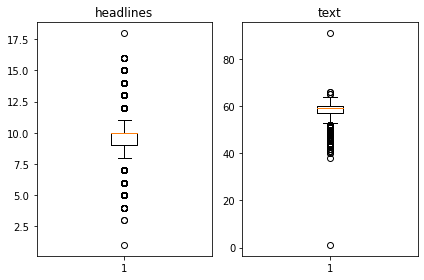

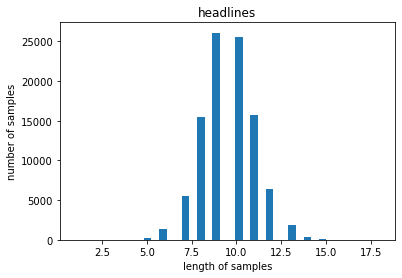

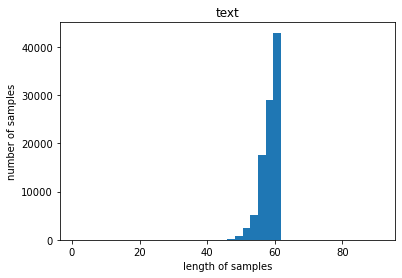

In [25]:
plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

텍스트의 최소 길이 : 1  
텍스트의 최대 길이 : 60  
텍스트의 평균 길이 : 35.09968483123221  
헤드라인의 최소 길이 : 1  
헤드라인의 최대 길이 : 16  
헤드라인의 평균 길이 : 9.299532330215534  

## - 데이터의 크기를 결정  

In [26]:
text_max_len = 60
headlines_max_len = 14

In [27]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
  

In [28]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.997448149654331
전체 샘플 중 길이가 14 이하인 샘플의 비율: 0.9992069947132981


In [29]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98031


## - 문장의 시작과 끝을 표시

In [30]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",sostoken upGrad learner switches to career in ...,upGrad learner switches to career in ML & Al w...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,sostoken Delhi techie wins free food from Swig...,Delhi techie wins free food from Swiggy for on...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,sostoken New Zealand end Rohit Sharma-led Indi...,New Zealand end Rohit Sharma-led India's 12-ma...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",sostoken Aegon life iTerm insurance plan helps...,Aegon life iTerm insurance plan helps customer...
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,"sostoken Have known Hirani for yrs, what if Me...","Have known Hirani for yrs, what if MeToo claim..."


In [31]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [32]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[21048  5613 89737 ... 30592 93296 41110]


In [33]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [34]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 19606


## - 데이터 나누기

훈련데이터와 테스트데이터 나누기  

In [35]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 78425
훈련 레이블의 개수 : 78425
테스트 데이터의 개수 : 19606
테스트 레이블의 개수 : 19606


훈련 데이터의 개수 : 78671  
훈련 레이블의 개수 : 78671  
테스트 데이터의 개수 : 19667  
테스트 레이블의 개수 : 19667  

## - 정수 인코딩
단어 집합(vocaburary) 만들기 및 정수 인코딩  
각 단어에 고유한 정수를 맵핑하는 작업  `단어 집합(vocaburary)`  
Keras의 토크나이저를 사용  

In [36]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

단어 집합이 생성  
각 단어에 고유한 정수가 부여  
단어 집합은 src_tokenizer.word_index에 저장  
`src_tokenizer.word_counts.items()`

In [37]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 91035
등장 빈도가 6번 이하인 희귀 단어의 수: 66327
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 24708
단어 집합에서 희귀 단어의 비율: 72.85879057505356
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.7302194424575226


단어 집합(vocabulary)의 크기 : 69557  
등장 빈도가 6번 이하인 희귀 단어의 수: 47423  
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22134   
단어 집합에서 희귀 단어의 비율: 68.1786160990267  
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.494565148505529  

등장 빈도가 threshold 값인 7회 미만, 즉, 6회 이하인 단어들은 단어 집합에서 무려 70% 이상을 차지하네요. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.39%밖에 되지 않아요.

그래서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 합니다. 위에서 이를 제외한 단어 집합의 크기를 8,233으로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 8000으로 제한해볼게요. 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있어요.

In [38]:
src_vocab = 22000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 22000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [39]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[84, 77, 107, 2589, 2824, 6725, 12, 8237, 15, 17, 12833, 413, 19237, 7709, 22, 1, 4488, 3056, 16761, 7, 1, 841, 5, 1618, 5775, 4, 87, 419, 19237, 13, 1, 5464, 413, 5, 588, 107, 6725, 11089, 20, 8734, 1048, 8878, 577, 5726, 7709, 6, 45, 413, 11850, 34, 40, 1350, 22, 1, 4040], [151, 1056, 1672, 8, 33, 313, 1, 391, 53, 474, 5, 203, 15, 1, 568, 61, 6, 904, 1061, 19238, 1, 391, 133, 1082, 5, 53, 510, 92, 7, 6, 1704, 3115, 12, 269, 7, 120, 362, 832, 170, 12, 163, 7, 1, 510, 1141, 15, 1575, 170, 6, 2396, 1745, 872], [1, 9143, 449, 639, 8346, 16112, 7, 37, 2407, 1931, 20, 4365, 7, 195, 81, 1, 133, 275, 639, 1568, 560, 4, 402, 11851, 16, 1185, 2486, 65, 2, 66, 128, 997, 106, 104, 210, 405, 3848, 15, 1, 1576, 1158, 689, 21, 910, 3, 158, 474, 11852, 3, 4973, 10831, 15, 3, 12834, 3462, 5666, 6, 8735, 6, 6652, 990]]


In [40]:
#headlines 토큰화
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었어요. 이는 tar_tokenizer.word_index에 저장되어있어요. tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장되어져 있는데, 이를 통해서 통계적인 정보를 얻어서, 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼게요.

In [41]:
threshold = 8
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 40635
등장 빈도가 7번 이하인 희귀 단어의 수: 31228
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9407
단어 집합에서 희귀 단어의 비율: 76.85000615233173
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.570118264665113


In [42]:
tar_vocab = 8800
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 4915, 257, 2133, 213, 5921, 6, 595, 24, 1494], [1, 441, 3141, 307, 227, 29, 204, 6, 172, 17], [1, 4, 1085, 3640, 1998, 2490, 239], [1, 47, 814, 3, 2206, 8, 4080, 908, 220], [1, 4081, 4489, 5256, 45, 415, 8, 487, 1074, 61]]
target
decoder  [[4915, 257, 2133, 213, 5921, 6, 595, 24, 1494, 2], [441, 3141, 307, 227, 29, 204, 6, 172, 17, 2], [4, 1085, 3640, 1998, 2490, 239, 2], [47, 814, 3, 2206, 8, 4080, 908, 220, 2], [4081, 4489, 5256, 45, 415, 8, 487, 1074, 61, 2]]


In [43]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 78425
훈련 레이블의 개수 : 78425
테스트 데이터의 개수 : 19605
테스트 레이블의 개수 : 19605


/home/aiffel-dj56/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## 패딩하기
텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해주어야 해야해요. 아까 정해두었던 최대 길이로 패딩해 줄 거에요. 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰줄게요.

In [44]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

## -인코더 모델 설계
이제는 모델을 설계할 시간이에요. 우선 함수형 API를 이용해서 인코더를 설계해 볼게요.

In [45]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

## -디코더 모델 설계

In [46]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [47]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## - 어텐션 매커니즘

In [48]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [49]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## - 모델 훈련

In [50]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)
          

Epoch 1/50
307/307 [==============================] - 130s 424ms/step - loss: 4.9605 - val_loss: 4.6075
Epoch 2/50
307/307 [==============================] - 129s 420ms/step - loss: 4.4370 - val_loss: 4.2517
Epoch 3/50
307/307 [==============================] - 130s 424ms/step - loss: 4.1193 - val_loss: 3.9984
Epoch 4/50
307/307 [==============================] - 129s 419ms/step - loss: 3.8841 - val_loss: 3.8240
Epoch 5/50
307/307 [==============================] - 129s 420ms/step - loss: 3.6944 - val_loss: 3.6822
Epoch 6/50
307/307 [==============================] - 129s 421ms/step - loss: 3.5346 - val_loss: 3.5695
Epoch 7/50
307/307 [==============================] - 129s 420ms/step - loss: 3.3995 - val_loss: 3.4793
Epoch 8/50
307/307 [==============================] - 128s 417ms/step - loss: 3.2841 - val_loss: 3.4109
Epoch 9/50
307/307 [==============================] - 128s 418ms/step - loss: 3.1829 - val_loss: 3.3541
Epoch 10/50
307/307 [==============================] - 128s 418m

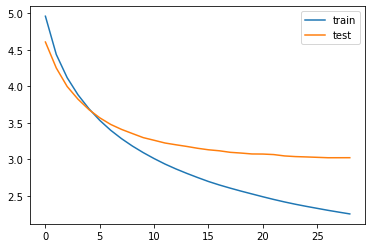

In [51]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해보세요.

## - 인퍼런스 모델 구현하기
테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로,   
필요한 3개의 사전을 아래와 같이 미리 준비

In [52]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다는 것, 알고 계시나요?

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했습니다.

그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다.

In [53]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

어텐션 메커니즘을 사용하는 출력층을 설계해 주세요.

In [54]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])
    

인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들어주세요.

In [55]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## - 모델 테스트하기  
테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편하겠죠. 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어볼게요. 함수를 만들 때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외시키고 Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외시키도록 만들거에요.

In [56]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp
    

In [57]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")
    

원문 : steel has filed a petition in the gujarat high court challenging the insolvency proceedings initiated against it based on rbi's directions essar steel said the company cleared a debt of ã¢ââ¹3 crore in 2016 17 and employs around 4 500 people the company said it was trying to a solution approved by its board and slammed rbi's decision as arbitrary 
실제 요약 : essar steel challenges rbi's insolvency move in gujarat hc 
예측 요약 :  tata steel moves hc against bankruptcy


원문 : the united kingdom has topped forbes' rankings of best countries in the world for business in 2018 for the first time up from fifth last year the list ranks 153 countries on 15 factors including property rights innovation taxes and red tape the uk is followed by new zealand and the netherlands while india was ranked 62nd on the list 
실제 요약 : uk tops list of best countries for business in 2018 
예측 요약 :  uk named world's top country in top rankings


원문 : kendall jenner gigi hadid and bella hadid walked the runway at 

예측 요약 :  name name on sale of its own show


원문 : ministry has included former indian cricketer virender sehwag and domestic cricketer vinay lamba in their anti doping appeals panel it is for the first time that cricketers have found a place in an anti doping panel of india's national anti doping agency this comes after a report claimed that an unnamed indian cricketer had tested positive for doping in 2016 
실제 요약 : virender sehwag part of sports anti doping panel 
예측 요약 :  sehwag sehwag banned from doping panel


원문 : vogue editor chambers who worked at british vogue for 36 years has claimed it took new editor in chief edward three minutes to fire her no one in the building knew it was going to happen except the man who did it she added at the time of her departure vogue had published an article announcing chambers would step down 
실제 요약 : it took them 3 minutes to fire me ex vogue editor 
예측 요약 :  i was bullets at the bus was fired for me vogue


원문 : kerala police has booked bjp mp 

예측 요약 :  tv actress accuses weinstein of rape scene


원문 : the oldest known in the world passed away on sunday a day after celebrating his 69th birthday his death appeared to be a heartbreaking accident as died after getting stuck in a maintenance hatch south florida museum ceo anne said weã¢ââre all devastated staff volunteers and board members considered him a star added 
실제 요약 : world's oldest dies a day after birthday 
예측 요약 :  world's oldest dies at kolkata


원문 : bengaluru and us based drug research startup research has raised 9 million in series a funding led by university of tokyo edge capital the round also saw participation from holdings and capital founded in 2014 is working on developing ways to fight bacterial drug resistance and take its drugs to clinical trials 
실제 요약 : drug research startup raises 9 million in series a 
예측 요약 :  startup raises 5 mn in series b funding


원문 : bcci's committee of administrators has said the board's treasurer had objected to the cash awa

## Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

In [58]:
import requests
from summa.summarizer import summarize

In [59]:
input_text = data['text']
print(input_text[:1500])

0       Saurav Kant, an alumnus of upGrad and IIIT-B's...
1       Kunal Shah's credit card bill payment platform...
2       New Zealand defeated India by 8 wickets in the...
3       With Aegon Life iTerm Insurance plan, customer...
4       Speaking about the sexual harassment allegatio...
                              ...                        
1501    An explosion caused due to illegal taps on a g...
1502    India's richest man Mukesh Ambani on Friday sa...
1503    Market regulator SEBI on Friday rejected India...
1504    Philippines' richest man Henry Sy, who started...
1505    Addressing the controversy surrounding the rel...
Name: text, Length: 1500, dtype: object


In [60]:
input_text[10]

"Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school. The cousins revealed their ordeal to the police and Child Welfare Committee after being brought back to Gorakhpur from Nepal, where they had fled to escape the torture."

In [61]:
for _ in range(10) :
    rnum = np.random.randint(len(input_text))
    print(f'Original Sentence:\n{input_text[rnum]}\n')
    print(f'Summary:\n{summarize(input_text[rnum], ratio=0.4)}')
    print('--'*50+'\n\n')

Original Sentence:
A new song titled 'Khatar Patar' from Varun Dhawan and Anushka Sharma starrer 'Sui Dhaaga- Made in India' has been released. Sung by Papon, the song has been composed by Anu Malik and written by Varun Grover. Sharing the song, Varun wrote, "Dreams do come true". Directed by Sharat Katariya, the film is scheduled to release on September 28.

Summary:
A new song titled 'Khatar Patar' from Varun Dhawan and Anushka Sharma starrer 'Sui Dhaaga- Made in India' has been released.
----------------------------------------------------------------------------------------------------


Original Sentence:
The Iraqi judiciary has been violating the rights of ISIS suspects with flawed trials and arbitrary detentions under harsh conditions, Human Rights Watch alleged on Tuesday. "Iraq's handling of ISIS trials is a missed opportunity to show the world that it's a nation ruled by laws and justice," it added. Recently, ISIS lost the last Iraqi town under its control.

Summary:
The Iraq

KeyError: 38061

## ◈ 루브릭
루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항/상세기준
1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.
분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.

2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.
모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.

3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.
두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.

## ◈ 결과 및 고찰

## ◈ 프로젝트 목표


## ◈ 학습 전제


## ◈ 준비물

## ◈ 목차
Step 1. 
Step 2. 
Step 3. 
Step 4. 
Step 5.
Step 6.
Step 7.
Step 8.
Step 9.


## ◈ 루브릭


## ◈ 결과 및 고찰